<a href="https://colab.research.google.com/github/jqshang/granger_protein_info/blob/main/Experiments/grangernn_causal_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jqshang/CSC2541.git
%cd CSC2541

Cloning into 'CSC2541'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 227 (delta 87), reused 155 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (227/227), 5.06 MiB | 7.59 MiB/s, done.
Resolving deltas: 100% (87/87), done.
/content/CSC2541


In [2]:
!pip -q install MDAnalysis MDAnalysisData

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 133.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset.syn_data import generate_synthetic_protein_data
from dataset.adk_data import generate_adk_data
from model.granger_nn import GrangerNeuralNet
from model.util import adjacency_to_digraph, plot_digraph, combine_position_angle_scores, print_sccs
from model.graph import filter_paths_new, build_scc_quotient_graph
from train_granger_nn import train_granger_net

/usr/local/lib/python3.12/dist-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string


In [5]:
positions, angles, amino_acids = generate_adk_data()

/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.12/dist-packages/MDAnalysis/analysis/dihedrals.py:444: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/MDAnalysis/analysis/dihedrals.py:574: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)


In [ ]:
# pairs = [("A1", "A16"), ("A16", "A17"), ("A17", "A30"), ("A30", "A36"), ("A30", "A16"), ("A36", "A50")]
# num_acids = 50
# num_steps = 200
# positions, angles, amino_acids = generate_synthetic_protein_data(num_acids, num_steps, pairs)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training Granger NN:   0%|          | 0/250 [00:00<?, ?it/s]

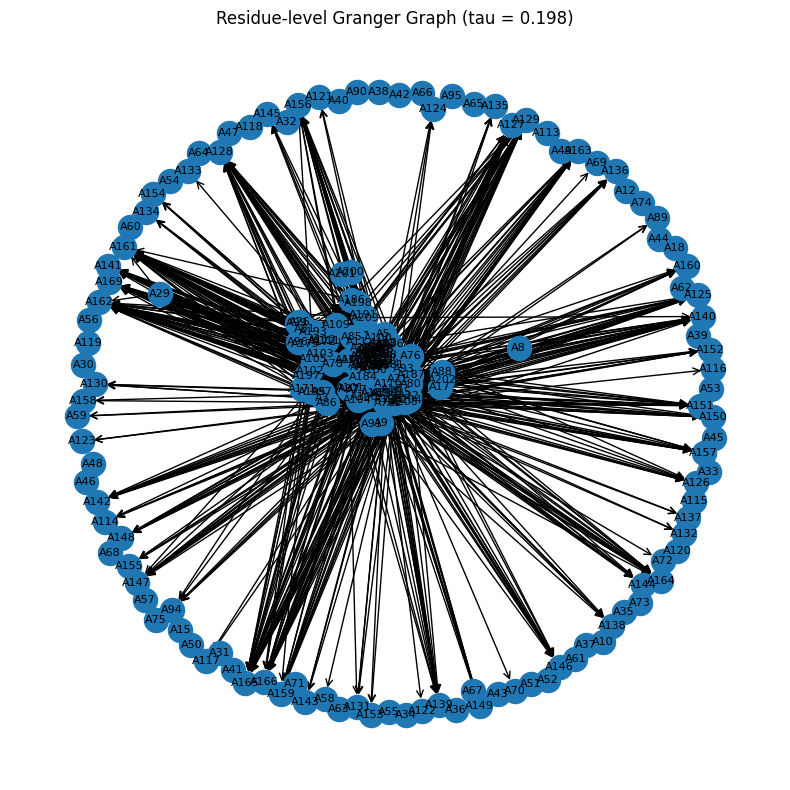

In [6]:
G_res_position, tau_position, S_res_position = train_granger_net(positions, H=10, n_epochs=250, batch_size=2048)
DG_res_position = adjacency_to_digraph(G_res_position,node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_position:.3f})"
plot_digraph(DG_res_position, node_names=amino_acids, title=plot_title)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training Granger NN:   0%|          | 0/250 [00:00<?, ?it/s]

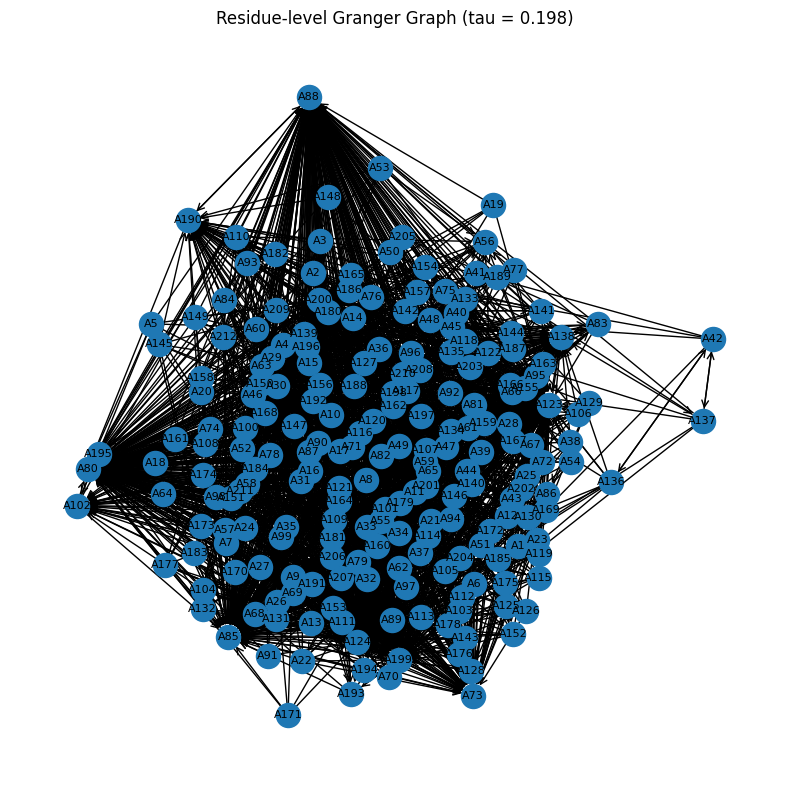

In [7]:
G_res_angle, tau_angle, S_res_angle = train_granger_net(angles, H=10, n_epochs=250, batch_size=2048)
DG_res_angle = adjacency_to_digraph(G_res_angle, node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_angle:.3f})"
plot_digraph(DG_res_angle, node_names=amino_acids, title=plot_title)

Combined threshold (tau_comb): 0.9976139
Number of residue edges in combined graph: 2181


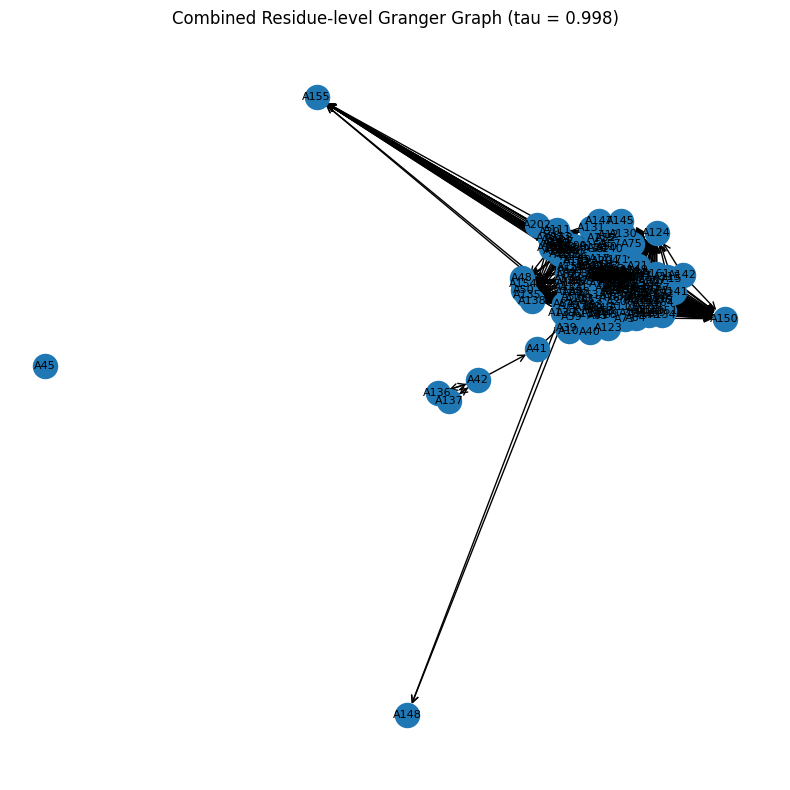

In [8]:
G_res_comb, tau_comb, S_res_comb = combine_position_angle_scores(S_res_position, S_res_angle)
print("Combined threshold (tau_comb):", tau_comb)
print("Number of residue edges in combined graph:", G_res_comb.sum())

DG_res_comb = adjacency_to_digraph(G_res_comb, node_names=amino_acids)
plot_title = f"Combined Residue-level Granger Graph (tau = {tau_comb:.3f})"
plot_digraph(DG_res_comb, node_names=amino_acids, title=plot_title)

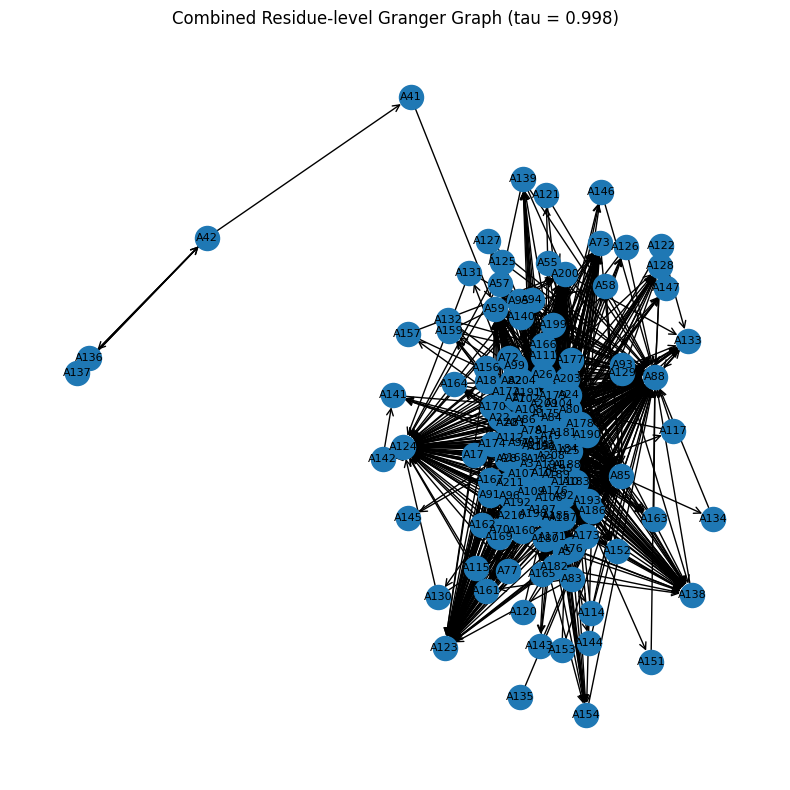

In [9]:
# assuming plot_digraph(DG, node_names, title) is already defined

allosteric_sites = [f"A{i}" for i in range(120, 158)]
active_sites = [f"A{i}" for i in range(28, 58)]

DG_signal, used_nodes, used_edges = filter_paths_new(
    DG_res_comb,
    amino_acids,
    allosteric_sites,
    active_sites,
)

# plot_title = f"Signaling pathways {allosteric_sites} → {active_sites}"
plot_digraph(DG_signal, node_names=amino_acids, title=plot_title)

Strongly connected components (SCCs):
  SCC 0: A1, A2, A3, A4, A5, A17, A18, A20, A22, A24, A25, A26, A27, A28, A55, A57, A58, A59, A70, A72, A73, A76, A77, A78, A79, A80, A81, A82, A83, A84, A85, A86, A87, A88, A91, A92, A93, A94, A95, A96, A97, A99, A101, A102, A103, A104, A105, A106, A107, A108, A109, A110, A111, A112, A114, A115, A117, A121, A123, A124, A125, A126, A127, A128, A129, A130, A131, A132, A133, A134, A138, A139, A140, A141, A142, A143, A144, A145, A146, A147, A151, A152, A154, A156, A157, A159, A160, A161, A162, A163, A164, A165, A166, A167, A168, A169, A170, A171, A172, A173, A174, A175, A176, A177, A178, A179, A180, A181, A182, A183, A184, A185, A186, A187, A188, A189, A190, A191, A192, A193, A194, A195, A196, A197, A198, A199, A200, A203, A204, A208, A209, A210, A211, A212
  SCC 1: A41
  SCC 2: A42, A136, A137
  SCC 3: A120
  SCC 4: A122
  SCC 5: A135
  SCC 6: A153


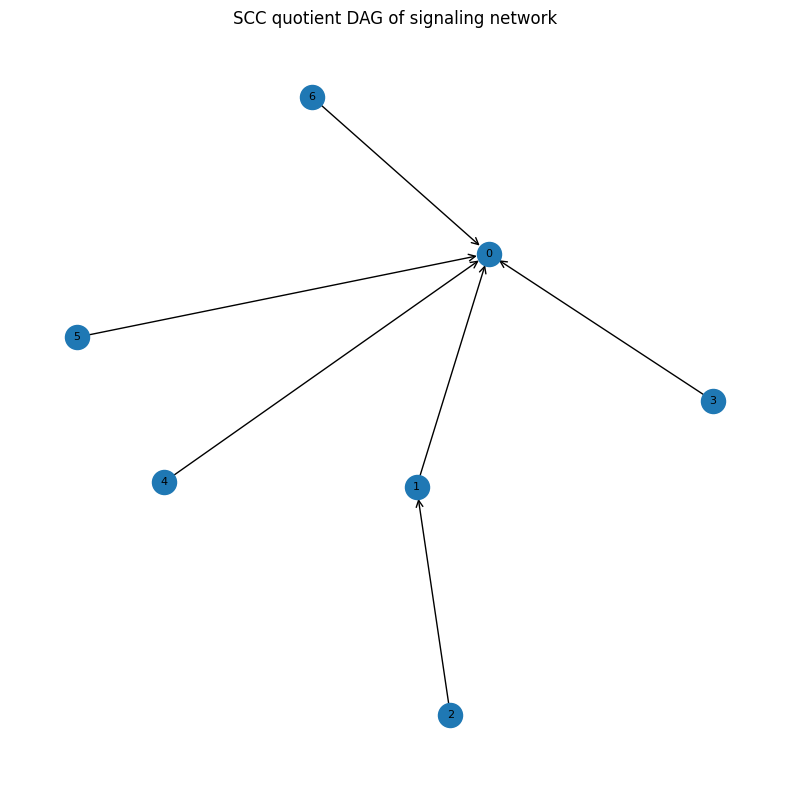

In [10]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph(Q, title=plot_title)